In [46]:
"""
# Análise de Apendicite em Crianças com Sistemas Inteligentes

Este notebook tem como objetivo desenvolver um sistema inteligente para:
1. Diagnosticar apendicite em crianças
2. Determinar a severidade do caso
3. Recomendar o tratamento adequado

Utilizaremos o dataset "Regensburg Pediatric Appendicitis" da UCI Machine Learning Repository.
"""

# IMPORTANDO BIBLIOTECAS
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo
from sklearn import preprocessing
from pickle import dump
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [47]:
"""
## 1. Carregamento e Pré-processamento dos Dados

Primeiro, vamos carregar o dataset e fazer uma inspeção inicial.
"""
# Carregando o dataset
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

# Separando features e targets
X = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets

# Combinando em um único DataFrame
df = pd.concat([X, y], axis=1)

# Exibindo informações iniciais
print("Dimensões do dataset:", df.shape)
print("\nPrimeiras linhas do dataset:")
display(df.head())

Dimensões do dataset: (782, 56)

Primeiras linhas do dataset:


,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Management,Severity,Diagnosis
0,12.68,16.9,female,148.0,37.0,3.0,4.0,3.0,yes,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conservative,uncomplicated,appendicitis
1,14.10,31.9,male,147.0,69.5,2.0,5.0,4.0,no,NaN,...,NaN,NaN,NaN,NaN,yes,NaN,NaN,conservative,uncomplicated,no appendicitis
2,14.14,23.3,female,163.0,62.0,4.0,5.0,3.0,no,NaN,...,NaN,NaN,NaN,NaN,yes,yes,NaN,conservative,uncomplicated,no appendicitis
3,16.37,20.6,female,165.0,56.0,3.0,7.0,6.0,no,NaN,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,conservative,uncomplicated,no appendicitis
4,11.08,16.9,female,163.0,45.0,3.0,5.0,6.0,yes,7.0,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,conservative,uncomplicated,appendicitis


In [48]:
"""
## 2. Normalização dos Targets (Diagnosis, Severity, Management)

Vamos tratar valores faltantes nas colunas de target.
"""
# Lista de colunas de target
target_cols = ['Diagnosis', 'Severity', 'Management']

# Tratando valores faltantes nos targets
for col in target_cols:
    if col in df.columns and df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Valores faltantes em '{col}' preenchidos com moda: {mode_val}")

Valores faltantes em 'Diagnosis' preenchidos com moda: appendicitis
Valores faltantes em 'Severity' preenchidos com moda: uncomplicated
Valores faltantes em 'Management' preenchidos com moda: conservative


In [49]:
"""
## 3. Normalização das Features

Agora vamos preparar as features para o modelo:
1. Tratamento de valores faltantes
2. Conversão de variáveis categóricas
3. Normalização numérica
"""
# Separando features e targets novamente
present_targets = [col for col in target_cols if col in df.columns]
df_targets = df[present_targets]
df_features = df.drop(columns=present_targets)

# Removendo colunas com muitos valores faltantes (>50%)
initial_columns = df_features.shape[1]
df_features = df_features.loc[:, df_features.isnull().mean() < 0.5]
print(f"Removidas {initial_columns - df_features.shape[1]} colunas com muitos valores faltantes")


Removidas 18 colunas com muitos valores faltantes


In [50]:
"""
### 3.1. Tratamento de Colunas Binárias (yes/no)
"""
# Mapeando colunas binárias de 'yes/no' para 1/0
binary_columns = {
    'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 
    'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
    'Loss_of_Appetite', 'Neutrophilia', 'Dysuria', 'Psoas_Sign',
    'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids'
}

for col in binary_columns:
    if col in df_features.columns:
        df_features[col] = df_features[col].map({'yes': 1, 'no': 0})

In [51]:
"""
### 3.2. Tratamento de Colunas Categóricas
"""
# Lista de colunas categóricas
categorical_cols = [
    'Sex', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 
    'Stool', 'Peritonitis'
]

# Filtrando apenas colunas presentes no dataset
categorical_cols = [col for col in categorical_cols if col in df_features.columns]

# Preenchendo valores faltantes com a moda
for col in categorical_cols:
    if df_features[col].isnull().any():
        mode_val = df_features[col].mode()[0]
        df_features[col] = df_features[col].fillna(mode_val)
        print(f"Valores faltantes em '{col}' preenchidos com moda: {mode_val}")

Valores faltantes em 'Sex' preenchidos com moda: male
Valores faltantes em 'Ketones_in_Urine' preenchidos com moda: no
Valores faltantes em 'RBC_in_Urine' preenchidos com moda: no
Valores faltantes em 'WBC_in_Urine' preenchidos com moda: no
Valores faltantes em 'Stool' preenchidos com moda: normal
Valores faltantes em 'Peritonitis' preenchidos com moda: no


In [52]:
"""
### 3.3. Tratamento de Colunas Numéricas
"""
# Lista de colunas numéricas
numerical_cols = [
    'Age', 'BMI', 'Height', 'Weight', 'Length_of_Stay', 'Appendix_Diameter',
    'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'RBC_Count',
    'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'CRP'
]

# Preenchendo valores faltantes com a mediana
for col in numerical_cols:
    if col in df_features.columns and df_features[col].isnull().any():
        median_val = df_features[col].median()
        df_features[col] = df_features[col].fillna(median_val)
        print(f"Valores faltantes em '{col}' preenchidos com mediana: {median_val:.2f}")

Valores faltantes em 'Age' preenchidos com mediana: 11.44
Valores faltantes em 'BMI' preenchidos com mediana: 18.06
Valores faltantes em 'Height' preenchidos com mediana: 149.65
Valores faltantes em 'Weight' preenchidos com mediana: 41.40
Valores faltantes em 'Length_of_Stay' preenchidos com mediana: 3.00
Valores faltantes em 'Appendix_Diameter' preenchidos com mediana: 7.50
Valores faltantes em 'Body_Temperature' preenchidos com mediana: 37.20
Valores faltantes em 'WBC_Count' preenchidos com mediana: 12.00
Valores faltantes em 'Neutrophil_Percentage' preenchidos com mediana: 75.50
Valores faltantes em 'RBC_Count' preenchidos com mediana: 4.78
Valores faltantes em 'Hemoglobin' preenchidos com mediana: 13.30
Valores faltantes em 'RDW' preenchidos com mediana: 12.70
Valores faltantes em 'Thrombocyte_Count' preenchidos com mediana: 276.00
Valores faltantes em 'CRP' preenchidos com mediana: 7.00


In [53]:
"""
### 3.4. Normalização Numérica e One-Hot Encoding
"""
# Normalizando colunas numéricas com MinMaxScaler
normalizador = preprocessing.MinMaxScaler()
df_features[numerical_cols] = normalizador.fit_transform(df_features[numerical_cols])

# Salvando o normalizador para uso futuro
dump(normalizador, open('../models/modelo_normalizador_num.pkl', 'wb'))

# Aplicando One-Hot Encoding nas colunas categóricas
df_features = pd.get_dummies(df_features, columns=categorical_cols, drop_first=True)

# Reunindo features e targets
df_processed = pd.concat([df_features.reset_index(drop=True), 
                        df_targets.reset_index(drop=True)], axis=1)

# Salvando dataset processado
df_processed.to_csv('../data/df_normalizado.csv', index=False)

print("\nDataset após processamento:")
display(df_processed.head())


Dataset após processamento:


,Age,BMI,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,Migratory_Pain,...,WBC_in_Urine_+++,WBC_in_Urine_no,"Stool_constipation, diarrhea",Stool_diarrhea,Stool_normal,Peritonitis_local,Peritonitis_no,Diagnosis,Severity,Management
0,0.690632,0.299044,0.683453,0.333603,0.074074,4.0,3.0,1.0,0.307692,0.0,...,False,True,False,False,True,False,True,appendicitis,uncomplicated,conservative
1,0.767974,0.793604,0.676259,0.661753,0.037037,5.0,4.0,0.0,0.335664,1.0,...,False,True,False,False,True,False,True,no appendicitis,uncomplicated,conservative
2,0.770153,0.510056,0.791367,0.586026,0.111111,5.0,3.0,0.0,0.335664,0.0,...,False,True,False,False,False,False,True,no appendicitis,uncomplicated,conservative
3,0.891612,0.421035,0.805755,0.525444,0.074074,7.0,6.0,0.0,0.335664,1.0,...,False,True,False,False,True,False,True,no appendicitis,uncomplicated,conservative
4,0.603486,0.299044,0.791367,0.414378,0.074074,5.0,6.0,1.0,0.300699,0.0,...,False,True,False,False,False,False,True,appendicitis,uncomplicated,conservative


In [54]:
"""
## 4. Balanceamento dos Dados

Como temos classes desbalanceadas, vamos aplicar SMOTE para balancear os dados.
"""
def balancear_dados(df, target_column):
    """Aplica SMOTE para balancear as classes do target especificado"""
    X = df.drop(columns=target_cols, errors='ignore')
    y = df[target_column]
    
    smote = SMOTE()
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    df_balanced = pd.concat([X_balanced, y_balanced], axis=1)
    return df_balanced

In [55]:
"""
## 5. Treinamento dos Modelos

Vamos treinar modelos separados para:
1. Diagnosis (diagnóstico de apendicite)
2. Severity (severidade do caso)
3. Management (tratamento recomendado)
"""
# Configurações comuns para todos os modelos
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

In [56]:
"""
### 5.1. Modelo para Diagnosis (Diagnóstico)
"""
print("\n=== Treinando modelo para Diagnosis ===")

# Pré-processamento robusto dos dados
print("\nVerificando valores faltantes antes do balanceamento:")
print(df_processed.isnull().sum())

# Criar cópia segura dos dados processados
df_diagnosis = df_processed.copy()

# Remover linhas com NaN nas features (mas manter targets)
feature_cols = [col for col in df_diagnosis.columns if col not in target_cols]
df_diagnosis = df_diagnosis.dropna(subset=feature_cols)

print(f"\nRemovidas {len(df_processed) - len(df_diagnosis)} linhas com valores faltantes")

# Balanceamento dos dados com tratamento de possíveis NaN residuais
def balancear_dados_seguro(df, target_column):
    """Função robusta de balanceamento com verificação de NaN"""
    X = df.drop(columns=target_cols, errors='ignore')
    y = df[target_column]
    
    # Verificação final de NaN
    if X.isnull().any().any():
        print("\nAviso: NaN residuais encontrados. Aplicando imputação...")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='most_frequent')
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Verificar balanceamento antes do SMOTE
    print("\nDistribuição de classes antes do balanceamento:")
    print(y.value_counts(normalize=True))
    
    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    try:
        X_balanced, y_balanced = smote.fit_resample(X, y)
    except Exception as e:
        print("\nErro durante o balanceamento:", str(e))
        print("Shape dos dados:", X.shape)
        print("Tipos de dados:", X.dtypes)
        raise
    
    print("\nDistribuição de classes após balanceamento:")
    print(pd.Series(y_balanced).value_counts(normalize=True))
    
    return pd.concat([pd.DataFrame(X_balanced, columns=X.columns), 
                    pd.Series(y_balanced, name=target_column)], axis=1)

# Aplicando balanceamento seguro
df_diagnosis = balancear_dados_seguro(df_diagnosis, 'Diagnosis')

# Preparação final dos dados
X = df_diagnosis.drop(columns=target_cols, errors='ignore')
y = df_diagnosis['Diagnosis']

# Verificação final de qualidade dos dados
print("\nDimensões finais dos dados:")
print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

assert not X.isnull().any().any(), "Existem valores NaN nas features!"
assert not y.isnull().any(), "Existem valores NaN no target!"

# Busca de hiperparâmetros com tratamento de erros
try:
    search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        n_iter=50,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        scoring='f1_macro'  # Métrica principal para otimização
    )
    search.fit(X, y)
    
    print("\nMelhores parâmetros para Diagnosis:")
    print(search.best_params_)
    
    # Treinamento do modelo final
    model = RandomForestClassifier(**search.best_params_, random_state=42)
    model.fit(X, y)
    
    # Validação cruzada robusta
    cv_results = cross_validate(
        model, 
        X, 
        y, 
        cv=10, 
        scoring=scoring_metrics,
        return_train_score=True
    )
    
    print("\nResultados da validação cruzada:")
    print(f"Acurácia média: {cv_results['test_accuracy'].mean():.2%} (±{cv_results['test_accuracy'].std():.2%})")
    print(f"Precisão média: {cv_results['test_precision_macro'].mean():.2%} (±{cv_results['test_precision_macro'].std():.2%})")
    print(f"Recall médio:   {cv_results['test_recall_macro'].mean():.2%} (±{cv_results['test_recall_macro'].std():.2%})")
    print(f"F1-score médio: {cv_results['test_f1_macro'].mean():.2%} (±{cv_results['test_f1_macro'].std():.2%})")
    
    # Salvando o modelo com verificação
    import os
    os.makedirs('../models', exist_ok=True)
    dump(model, open('../models/modeloDiagnosis.pkl', 'wb'))
    print("\nModelo salvo com sucesso em '../models/modeloDiagnosis.pkl'")
    
except Exception as e:
    print("\nErro durante o treinamento do modelo:", str(e))
    raise


=== Treinando modelo para Diagnosis ===

Verificando valores faltantes antes do balanceamento:
Age                                   0
BMI                                   0
Height                                0
Weight                                0
Length_of_Stay                        0
Alvarado_Score                       52
Paedriatic_Appendicitis_Score        52
Appendix_on_US                        5
Appendix_Diameter                     0
Migratory_Pain                        9
Lower_Right_Abd_Pain                  8
Contralateral_Rebound_Tenderness     15
Coughing_Pain                        16
Nausea                                8
Loss_of_Appetite                     10
Body_Temperature                      0
WBC_Count                             0
Neutrophil_Percentage                 0
Neutrophilia                         50
RBC_Count                             0
Hemoglobin                            0
RDW                                   0
Thrombocyte_Count       

In [57]:
### 5.2. Modelo para Severity (Severidade)
"""
Apenas para casos diagnosticados como apendicite
"""
print("\n=== Treinando modelo para Severity ===")

# Pré-processamento robusto dos dados
print("\nVerificando valores faltantes nos dados originais:")
print(df_processed.isnull().sum())

# Filtrar apenas casos de apendicite e criar cópia segura
df_severity = df_processed[df_processed['Diagnosis'] == 'appendicitis'].copy()
print(f"\nTotal de casos de apendicite: {len(df_severity)}")

# Remover linhas com NaN nas features (mas manter targets)
feature_cols = [col for col in df_severity.columns if col not in target_cols]
df_severity = df_severity.dropna(subset=feature_cols)
print(f"Removidas {len(df_processed[df_processed['Diagnosis'] == 'appendicitis']) - len(df_severity)} linhas com valores faltantes")

# Balanceamento dos dados com tratamento seguro
def balancear_dados_seguro(df, target_column):
    """Função robusta de balanceamento com verificação de NaN"""
    X = df.drop(columns=target_cols, errors='ignore')
    y = df[target_column]
    
    # Verificação final de NaN
    if X.isnull().any().any():
        print("\nAviso: NaN residuais encontrados. Aplicando imputação...")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='most_frequent')
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Verificar balanceamento antes do SMOTE
    print("\nDistribuição original de classes:")
    print(y.value_counts(normalize=True))
    
    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    try:
        X_balanced, y_balanced = smote.fit_resample(X, y)
    except Exception as e:
        print("\nErro durante o balanceamento:", str(e))
        print("Shape dos dados:", X.shape)
        print("Tipos de dados:", X.dtypes)
        print("Valores NaN totais:", X.isnull().sum().sum())
        raise
    
    print("\nDistribuição de classes após balanceamento:")
    print(pd.Series(y_balanced).value_counts(normalize=True))
    
    return pd.concat([pd.DataFrame(X_balanced, columns=X.columns), 
                    pd.Series(y_balanced, name=target_column)], axis=1)

# Aplicando balanceamento seguro
try:
    df_severity = balancear_dados_seguro(df_severity, 'Severity')
except Exception as e:
    print("\nFalha ao balancear dados para Severity:", str(e))
    raise

# Preparação final dos dados
X = df_severity.drop(columns=target_cols, errors='ignore')
y = df_severity['Severity']

# Verificação final de qualidade dos dados
print("\nDimensões finais dos dados para Severity:")
print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

assert not X.isnull().any().any(), "Existem valores NaN nas features!"
assert not y.isnull().any(), "Existem valores NaN no target!"

# Busca de hiperparâmetros com tratamento de erros
try:
    print("\nIniciando busca de hiperparâmetros...")
    search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        n_iter=50,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        scoring='f1_macro'  
    )
    search.fit(X, y)
    
    print("\nMelhores parâmetros para Severity:")
    print(search.best_params_)
    
    # Treinamento do modelo final
    print("\nTreinando modelo final...")
    model = RandomForestClassifier(**search.best_params_, random_state=42)
    model.fit(X, y)
    
    # Validação cruzada robusta
    print("\nRealizando validação cruzada...")
    cv_results = cross_validate(
        model, 
        X, 
        y, 
        cv=10, 
        scoring=scoring_metrics,
        return_train_score=True
    )
    
    print("\nResultados da validação cruzada para Severity:")
    print(f"Acurácia média: {cv_results['test_accuracy'].mean():.2%} (±{cv_results['test_accuracy'].std():.2%})")
    print(f"Precisão média: {cv_results['test_precision_macro'].mean():.2%} (±{cv_results['test_precision_macro'].std():.2%})")
    print(f"Recall médio:   {cv_results['test_recall_macro'].mean():.2%} (±{cv_results['test_recall_macro'].std():.2%})")
    print(f"F1-score médio: {cv_results['test_f1_macro'].mean():.2%} (±{cv_results['test_f1_macro'].std():.2%})")
    
    # Salvando o modelo com verificação
    import os
    os.makedirs('../models', exist_ok=True)
    dump(model, open('../models/modeloSeverity.pkl', 'wb'))
    print("\nModelo de Severity salvo com sucesso em '../models/modeloSeverity.pkl'")
    
    # Análise de importância das features
    print("\nTop 10 features mais importantes:")
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    print(feature_importances.sort_values(ascending=False).head(10))
    
except Exception as e:
    print("\nErro durante o treinamento do modelo de Severity:", str(e))
    raise


=== Treinando modelo para Severity ===

Verificando valores faltantes nos dados originais:
Age                                   0
BMI                                   0
Height                                0
Weight                                0
Length_of_Stay                        0
Alvarado_Score                       52
Paedriatic_Appendicitis_Score        52
Appendix_on_US                        5
Appendix_Diameter                     0
Migratory_Pain                        9
Lower_Right_Abd_Pain                  8
Contralateral_Rebound_Tenderness     15
Coughing_Pain                        16
Nausea                                8
Loss_of_Appetite                     10
Body_Temperature                      0
WBC_Count                             0
Neutrophil_Percentage                 0
Neutrophilia                         50
RBC_Count                             0
Hemoglobin                            0
RDW                                   0
Thrombocyte_Count           


=== Treinando modelo para Management ===

Verificando valores faltantes nos dados originais:
Age                                   0
BMI                                   0
Height                                0
Weight                                0
Length_of_Stay                        0
Alvarado_Score                       52
Paedriatic_Appendicitis_Score        52
Appendix_on_US                        5
Appendix_Diameter                     0
Migratory_Pain                        9
Lower_Right_Abd_Pain                  8
Contralateral_Rebound_Tenderness     15
Coughing_Pain                        16
Nausea                                8
Loss_of_Appetite                     10
Body_Temperature                      0
WBC_Count                             0
Neutrophil_Percentage                 0
Neutrophilia                         50
RBC_Count                             0
Hemoglobin                            0
RDW                                   0
Thrombocyte_Count         

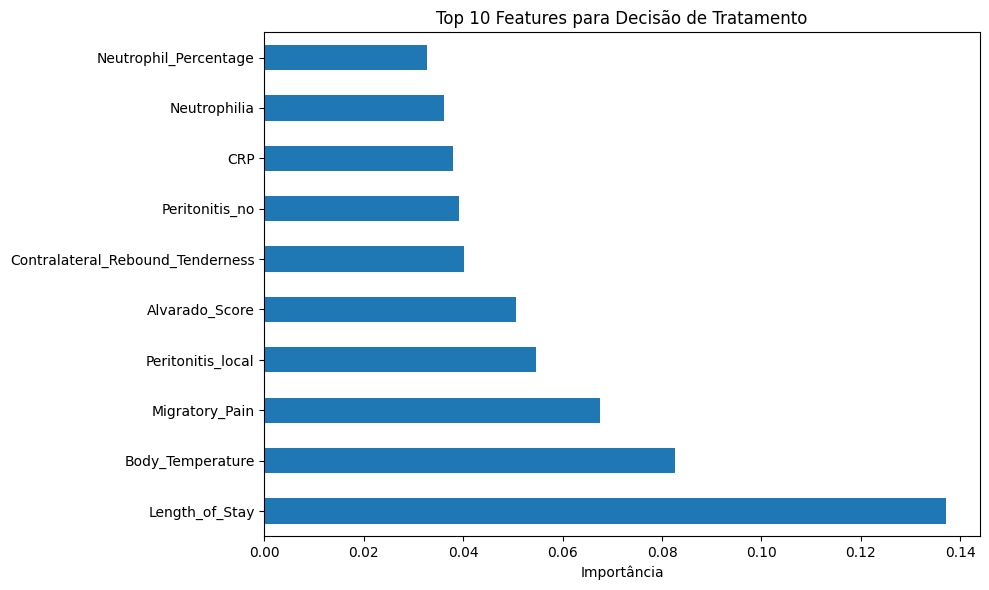


Processo completo para modelo de tratamento concluído com sucesso!


In [58]:
### 5.3. Modelo para Management (Tratamento)
"""
Apenas para casos diagnosticados como apendicite
"""
print("\n=== Treinando modelo para Management ===")

# Verificação inicial dos dados
print("\nVerificando valores faltantes nos dados originais:")
print(df_processed.isnull().sum())

# Filtrar casos de apendicite com cópia segura
df_management = df_processed[df_processed['Diagnosis'] == 'appendicitis'].copy()
print(f"\nTotal de casos de apendicite: {len(df_management)}")

# Remover linhas com NaN nas features
feature_cols = [col for col in df_management.columns if col not in target_cols]
df_management = df_management.dropna(subset=feature_cols)
print(f"Removidas {len(df_processed[df_processed['Diagnosis'] == 'appendicitis']) - len(df_management)} linhas com valores faltantes")

# Função de balanceamento robusto
def balancear_management(df, target_column):
    """Balanceamento seguro para dados de tratamento"""
    X = df.drop(columns=target_cols, errors='ignore')
    y = df[target_column]
    
    # Verificação final de NaN
    if X.isnull().any().any():
        print("\nAviso: NaN encontrados. Aplicando imputação...")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='most_frequent')
        X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Verificar distribuição de classes
    print("\nDistribuição original das opções de tratamento:")
    print(y.value_counts(normalize=True))
    
    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    try:
        X_balanced, y_balanced = smote.fit_resample(X, y)
    except Exception as e:
        print("\nErro no balanceamento:", str(e))
        print("Shape dos dados:", X.shape)
        print("Tipos de dados:", X.dtypes)
        print("Valores NaN:", X.isnull().sum().sum())
        raise
    
    print("\nDistribuição balanceada das opções de tratamento:")
    print(pd.Series(y_balanced).value_counts(normalize=True))
    
    return pd.concat([pd.DataFrame(X_balanced, columns=X.columns),
                    pd.Series(y_balanced, name=target_column)], axis=1)

# Aplicar balanceamento seguro
try:
    df_management = balancear_management(df_management, 'Management')
except Exception as e:
    print("\nFalha ao balancear dados de tratamento:", str(e))
    raise

# Preparar dados finais
X = df_management.drop(columns=target_cols, errors='ignore')
y = df_management['Management']

# Verificação final
print("\nDimensões finais para modelo de tratamento:")
print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

assert not X.isnull().any().any(), "Valores NaN nas features!"
assert not y.isnull().any(), "Valores NaN no target!"

# Busca de hiperparâmetros com tratamento robusto
try:
    print("\nIniciando busca de hiperparâmetros para tratamento...")
    search = RandomizedSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        n_iter=50,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        scoring='f1_macro'
    )
    search.fit(X, y)
    
    print("\nMelhores parâmetros para Management:")
    print(search.best_params_)
    
    # Treinar modelo final
    print("\nTreinando modelo final de tratamento...")
    model = RandomForestClassifier(**search.best_params_, random_state=42)
    model.fit(X, y)
    
    # Validação cruzada completa
    print("\nRealizando validação cruzada...")
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=10,
        scoring=scoring_metrics,
        return_train_score=True
    )
    
    print("\nResultados para modelo de tratamento:")
    print(f"Acurácia média: {cv_results['test_accuracy'].mean():.2%} (±{cv_results['test_accuracy'].std():.2%})")
    print(f"Precisão média: {cv_results['test_precision_macro'].mean():.2%} (±{cv_results['test_precision_macro'].std():.2%})")
    print(f"Recall médio: {cv_results['test_recall_macro'].mean():.2%} (±{cv_results['test_recall_macro'].std():.2%})")
    print(f"F1-score médio: {cv_results['test_f1_macro'].mean():.2%} (±{cv_results['test_f1_macro'].std():.2%})")
    
    # Salvar modelo com verificação
    import os
    os.makedirs('../models', exist_ok=True)
    dump(model, open('../models/modeloManagement.pkl', 'wb'))
    print("\nModelo de tratamento salvo em '../models/modeloManagement.pkl'")
    
    # Análise de importância das features
    print("\nTop 10 features mais importantes para decisão de tratamento:")
    importances = pd.Series(model.feature_importances_, index=X.columns)
    print(importances.sort_values(ascending=False).head(10))
    
    # Plotar importância das features
    plt.figure(figsize=(10, 6))
    importances.nlargest(10).plot(kind='barh')
    plt.title('Top 10 Features para Decisão de Tratamento')
    plt.xlabel('Importância')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print("\nErro no treinamento do modelo de tratamento:", str(e))
    raise

print("\nProcesso completo para modelo de tratamento concluído com sucesso!")